# Approximate $\pi$

The way not not steady functions could be used in the project is illustrated in a well known basic example for the use of the Monte Carlo method. This is the approximation of pi. Here the it is used that the area of the (unit) circle is proportional to pi. Hence it is possible to approximate $\pi$ by setting all points in the circle to 1 and all others to 0. Then the average of these value converges to $\pi$. Because we restrict our self to the interval   $[0,1]^n$, we have
$$
\pi = 4 \cdot A(2,q)
$$
and 
$$
\pi = 6 \cdot A(3,q),
$$

with $A(n,q)$ being the result of the Smolyak algorithm in $n$ dimensions and the degree of approximation q. Because the function is not derivable, it is not possible to estimate the error for the algorithm for the deterministic quadratures. We will just compare them to the value of $\pi$ used by numpy. 

In [1]:
import os
os.chdir("..")


import Methodes.Smolyak_one as Smolyak_one
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
import itertools as itt

## The functions used 

In [2]:
# Functions receiving 2 or 3 matrices of the the dimension 2 or 3. Each matirce contains the coordinate in 
# the component x, y or z. The function returns a martice of the shape of the input components with 1 if 
# the 2-norm of the coordinate is smaller or equal 1 and 0 otherwise. 
def circle(X_1, X_2):
    save_mat = np.ones(X_1.shape)
    
    for index_vec, vectors in enumerate(X_1):
        for index_col, x_1 in enumerate(vectors):

            if x_1**2 + X_2[index_vec, index_col]**2 > 1:
                save_mat[index_vec, index_col] = 0
    return save_mat
    
def ball(X_1, X_2, X_3): 
    save_mat = np.ones(X_1.shape)
    for index_mat, matrix in enumerate(X_1):
        for index_vec, vectors in enumerate(matrix):
            for index_col, x_1 in enumerate(vectors):

                if x_1**2 + X_2[index_mat, index_vec, index_col]**2 + X_3[index_mat, index_vec, index_col]**2 > 1:
                    save_mat[index_mat, index_vec, index_col] = 0
    return save_mat

color_str = [ "fuchsia", "navy", "limegreen", "red"]
variables = []
for f in range(3):
    variables.append(sp.Symbol("x_" + str(f)))

option_list = ["Trapezoidal",
               "Monte Carlo (nested)",
               "Monte Carlo (non-nested)",
               "Quasi-Monte Carlo"]

# Approximation of pi with different q and degrees of approx. 
lower_bound, upper_bound = [8,15]
approx_pi_circle = np.empty([len(option_list), upper_bound - lower_bound])
for index_option, option in enumerate(option_list):
    for index_q, degree_of_approx in enumerate(range(lower_bound, upper_bound)):
        approx_pi_circle[index_option, index_q] = 4 * Smolyak_one.controller_smolyak(circle, variables[:2], option, degree_of_approx, function_given=True, no_error=True)[0]

approx_pi_ball = np.empty([len(option_list), upper_bound - lower_bound])
for index_option, option in enumerate(option_list):
    for index_q, degree_of_approx in enumerate(range(lower_bound, upper_bound)):
        approx_pi_ball[index_option, index_q] = 6 * Smolyak_one.controller_smolyak(ball, variables, option, degree_of_approx, function_given=True, no_error=True)[0]


## Illustration of the principle of approximation for 2 dimensions

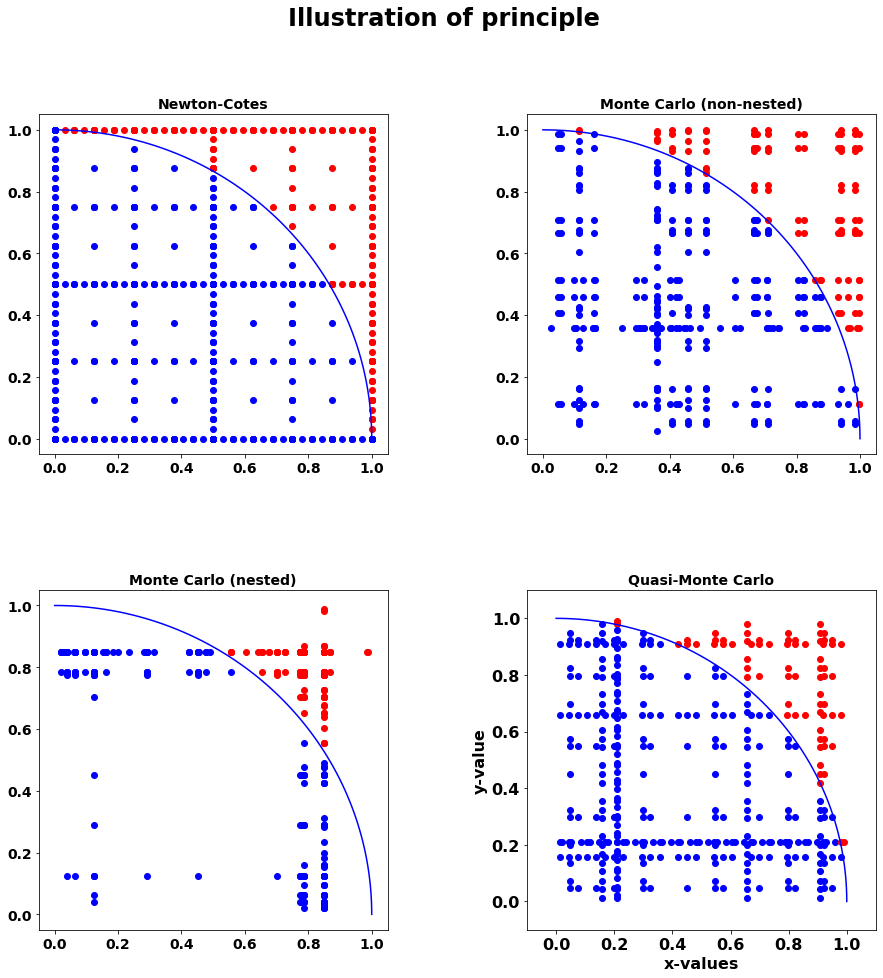

In [3]:
plt.rc('font', size=14, weight="bold")
def grid_points(quadrature: str, q: int, a=0,b=1):
    list_of_points = []
    dim = 2

    # Because the points used for the deterministic quadratures are not changed, it is faster to call them
    # at the beginning before starting the Smolyak alg.
    if "Carlo" in quadrature:
        q = q + 1

    # For every one dimensional degree of approx.  a weights and points vector
    for i in range(1, (q - dim + 2)):
        
        # One option for Newton-Cotes and Trapezoidal quadrature, because 
        if quadrature == "Newton-Cotes" or quadrature == "Trapezoidal":
            points, weights = Smolyak_one.one_dim_trapezoidal(i, a, b)
            
        if quadrature ==  "Monte Carlo (nested)" and i >1:
            points, weights = Smolyak_one.monte_carlo_quad(i-1, a, b)
            points = np.concatenate([list_of_points[-1], points])


        if quadrature ==  "Monte Carlo (non-nested)"or (quadrature == "Monte Carlo (nested)" and i == 1)  :
            points, weights = Smolyak_one.monte_carlo_quad(i, a, b)
            
        if quadrature ==  "Quasi-Monte Carlo":
            points, weights = Smolyak_one.qmc_quad(i, a, b)
            
        list_of_points.append(points)
        
    # Now we get the combinations of one-dimensional degrees of approx. in Q(q,d)        
    rng = list(range(q)) * dim
    rng = [x + 1 for x in rng]

    possible_combinations = list(set(i for i in itt.permutations(rng, dim) if (q - dim) < sum(i) < q + 1))
    number_approx = len(possible_combinations)
    meshgrid_list_x = []
    meshgrid_list_y = []
    for i in range(number_approx):

        # gridpoints and the weight vectors are put into separate lists to make it easier to
        # make a meshgrid
        current_tuple = possible_combinations[i]
        current_points = []

        for j in range(len(current_tuple)):
            current_points.append(list_of_points[current_tuple[j] - 1])

        # meshgrid yields a np.array with all coordinates needed for alg
        # coordinate and respective weight could be found in the same places in the array
        meshgrid_points = np.array(np.meshgrid(*current_points))
        meshgrid_list_x.append(meshgrid_points[0])
        meshgrid_list_y.append(meshgrid_points[1])
        
    return [meshgrid_list_x, meshgrid_list_y] 

def make_plot_of_grids():
    a = 0
    b = 1
    option_list = ["Newton-Cotes",
               "Monte Carlo (nested)",
               "Monte Carlo (non-nested)",
               "Quasi-Monte Carlo"]
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(len(option_list)):
        x, y = grid_points(option_list[i], 6)
        circle_pi = list()
        for index_x, _ in enumerate(x):
            
            circle_pi.append(circle(x[index_x], y[index_x])) 
            ax[i%2,int(i/2)].scatter(x[index_x][circle_pi[-1]==1], y[index_x][circle_pi[-1]==1], color="blue",label="1")
            ax[i%2,int(i/2)].scatter(x[index_x][circle_pi[-1]==0], y[index_x][circle_pi[-1]==0], color="red",label="0")
            ax[i%2,int(i/2)].set_title(option_list[i],fontsize=14, fontweight="bold")
        
        # print circle
        x_circle = np.linspace(0,np.pi / 2,100)
        r_x = np.cos(x_circle)
        r_y = np.sin(x_circle)
        ax[i%2,int(i/2)].plot(r_x,r_y,color="blue")

    # Some cosmetic changes in plot
    plt.xlabel("x-values", fontsize=16, fontweight="bold")
    plt.ylabel("y-value", fontsize=16, fontweight="bold")
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(a - (b - a) / 10, b + (b - a) / 10)
    plt.ylim(a - (b - a) / 10, b + (b - a) / 10)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    


    fig.suptitle("Illustration of principle", fontsize=24,fontweight="bold")
    plt.show()

make_plot_of_grids()

The blue points coincides with the points with value 1 and the red ones with the value 0. 

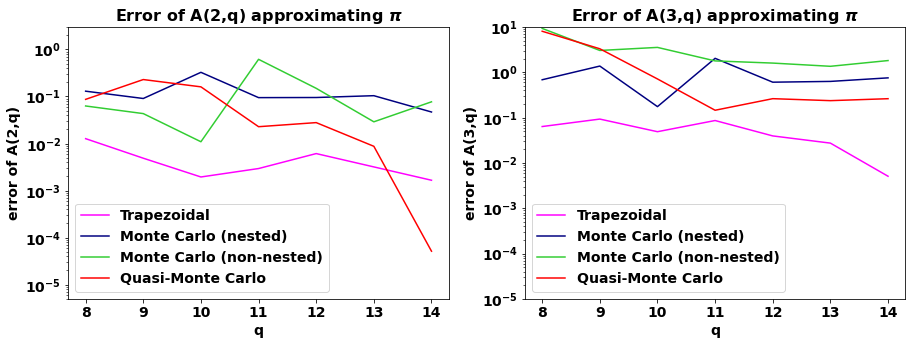

In [4]:
fig, ax = plt.subplots(1,2,figsize=(15,5))        

for index_option, option in enumerate(option_list):
    ax[0].plot(range(lower_bound, upper_bound), abs(np.pi-approx_pi_circle[index_option, :]), color = color_str[index_option], 
             label=option)
ax[0].set_yscale("log")
ax[0].set_ylim(0.000005,3)
ax[0].set_ylabel("error of A(2,q)",fontsize=14, fontweight="bold")
ax[0].set_xlabel("q",fontsize=14, fontweight="bold")
ax[0].set_xticks(list(range(lower_bound, upper_bound)))
ax[0].set_xticklabels(list(range(lower_bound, upper_bound)),fontsize=14, fontweight="bold")
ax[0].set_title(r"Error of A(2,q) approximating $\pi$",fontsize=16, fontweight="bold")
ax[0].legend()


for index_option, option in enumerate(option_list):
    ax[1].plot(range(lower_bound, upper_bound), abs(np.pi-approx_pi_ball[index_option, :]), color = color_str[index_option], 
             label=option)
ax[1].set_yscale("log")
ax[1].set_ylabel("error of A(3,q)",fontsize=14, fontweight="bold")
ax[1].set_xlabel("q",fontsize=14, fontweight="bold")
ax[1].set_xticks(list(range(lower_bound, upper_bound)))
ax[1].set_xticklabels(list(range(lower_bound, upper_bound)),fontsize=14, fontweight="bold")
ax[1].set_title(r"Error of A(3,q) approximating $\pi$",fontsize=16, fontweight="bold")
ax[1].legend()
ax[1].set_ylim(0.00001,10)
plt.show()